In [2]:
import xarray as xr
import numpy  as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import skill_metrics as sm

2020.12.10<br>
计算逐月平均图的空间相关所得到的taylor图。

In [27]:
precip_obs.sel(time = slice(year_ind+"-"+months[4],year_ind+"-"+months[4]))

<xarray.DataArray 'precip_CMORPH' (time: 31, lat: 160, lon: 320)>
[1587200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2008-08-01 2008-08-02 ... 2008-08-31
  * lat      (lat) float32 15.125 15.375 15.625 15.875 ... 54.375 54.625 54.875
  * lon      (lon) float32 60.125 60.375 60.625 ... 139.375 139.625 139.875
Attributes:
    lev:        1.0
    long_name:  yyyyy CMORPH Version 1.o daily precipitation (mm)

In [28]:
year = ["2004","2005","2006","2007","2008"]
months = ["4","5","6","7","8"]
year_stats = {} # 当年的统计量
for year_ind in year:
    # xarray 读取数据
    diri = "/m2data2/yycheng/yycheng/MPAS/92-25km_VR_"+year_ind+"/postprocess/temp_data/"
    fili = year_ind+"_daily_precip_combine_CMORPH_MPAS.nc"
    ds_disk = xr.open_dataset(diri + fili)
    precip_obs = ds_disk["precip_CMORPH"]
    precip_mod = ds_disk["precip_MPAS"]
    # 计算逐年05-08序列
    # year_obs_mean = precip_obs.mean(dim=["lon","lat"])
    # year_mod_mean = precip_mod.mean(dim=["longitude","latitude"])
    # 拆分逐月，计算统计量
    month_stats = {} # 逐月的统计量
    for month_ind in months:
        #  taylor_stats1.append( sm.taylor_statistics(np.array(obs_mean),np.array(mod_mean)) )
        months_obs_mean = precip_obs.sel(time = slice(year_ind+"-"+month_ind,year_ind+"-"+month_ind)).mean(dim=["time"])
        months_mod_mean = precip_mod.sel(Time = slice(year_ind+"-"+month_ind,year_ind+"-"+month_ind)).mean(dim=["Time"]) # MPAS中奇怪的时间坐标名称Time
        # print(months_obs_mean.shape)
        # pred1 , refer
        month_stats[month_ind] = sm.taylor_statistics(np.array(months_mod_mean).ravel(),np.array(months_obs_mean).ravel())
    # 逐月合并进逐年
    year_stats[year_ind] = month_stats


In [30]:
# 例如读出2003-04的泰勒图统计信息
# 0 - ref 1 - test
year_stats['2004']['8']

{'ccoef': array([1.        , 0.54086628]),
 'crmsd': [0.0, 6.2377716063742294],
 'sdev': [4.617062, 7.378668506852136]}

2020.12.2<br>
将不同时间段的 taylor diagram 进行归一化

泰勒图绘制：考虑绘制不同年份的同一月的泰勒图，使用了normalized,obs始终在（1，0）的位置

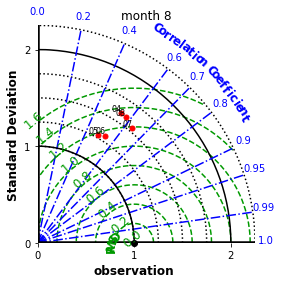

In [70]:
# >> taylor_diagram
# 不是多个模型对同一时段的模拟，绘制taylor图只是说明下相关性
# 逐年的固定某个月份 下面的 rmsd_select_year 在 months 中的范围大致是相同的
# label = ['Non-Dimensional Observation', 'M1']
year_select = ["2004","2005","2006","2007","2008"]
# months = ["4","5","6","7","8"]
months = ['8']
rmsd_select_year='2004'

for month_ind in months:
    sdev  = []
    crmsd = []
    ccoef = []
    sdev_obs = []
    # statistics can be normalized
    # obs sdev=1 crmsd=0 ccoef=1
    sdev.append(year_stats[rmsd_select_year][month_ind]['sdev'][0]/year_stats[rmsd_select_year][month_ind]['sdev'][0])
    crmsd.append(year_stats[rmsd_select_year][month_ind]['crmsd'][0]/year_stats[rmsd_select_year][month_ind]['sdev'][0])
    ccoef.append(year_stats[rmsd_select_year][month_ind]['ccoef'][0])
    for year_ind in year_select:

        # print( year_stats[year_ind][select_month]['sdev'][1] )
        # for i in year_stats[year_ind]:
        # # taylor_stats1[:]["ccoef"]
        #     # print(i['crmsd'][1])
        # for month_ind in months:

        sdev.append(year_stats[year_ind][month_ind]['sdev'][1]/year_stats[year_ind][month_ind]['sdev'][0])
        crmsd.append(year_stats[year_ind][month_ind]['crmsd'][1]/year_stats[year_ind][month_ind]['sdev'][0])
        ccoef.append(year_stats[year_ind][month_ind]['ccoef'][1])
            # sdev_obs.append(i['sdev'][0])
        
    sdev  = np.array(sdev)
    crmsd = np.array(crmsd)
    ccoef = np.array(ccoef)

    intervalsCOR = np.concatenate((np.arange(0,1.0,0.2), [0.7,0.9, 0.95, 0.99, 1]))

    ax = sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = ["obs","04","05","06","07","08"], 
                        tickRMS = np.arange(0,1.8,0.2), tickRMSangle = 130, 
                        # colRMS = 'm', styleRMS = ':', widthRMS = 2.0,
                        tickCOR = intervalsCOR,
                        tickSTD = [0,1,1.25,1.5,1.75,2], axismax = 2.25, 
                        showlabelsSTD = 'on',
                        rmslabelformat = ':.1f',
                        styleOBS = '-', 
                        colOBS = 'k',
                        markerobs = 'o', 
                        titleOBS = 'observation')
    plt.title("month "+month_ind)
    pic_output_path = "/m2data2/yycheng/playground/MPAS_case_study/case_template/92-25km_vr_case_postprocess/visualization/check_cmorph_vr/output_pic/taylor/taylor_space/"
    plt.savefig(pic_output_path + "taylor_normalized_2003-2009_space_"+month_ind,dpi=300)
    del(ax)

In [57]:
np.arange(0,2.25,2)

array([0., 2.])